In [60]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Đọc dữ liệu từ file CSV
data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

# Tạo cột datetime từ các cột year, month, day, hour
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']].assign(MINUTE=0, SECOND=0))
data.set_index('datetime', inplace=True)

# Chuyển cột pm2.5 thành kiểu số, thay "NA" bằng NaN
data['pm2.5'] = pd.to_numeric(data['pm2.5'], errors='coerce')

# Tiền xử lý: Nội suy các giá trị thiếu (NaN) trong cột pm2.5
data['pm2.5'] = data['pm2.5'].interpolate(method='linear')

# Lấy dữ liệu PM2.5
pm25 = data['pm2.5']

# Xây dựng mô hình ARIMA(1,1,1)
model = ARIMA(pm25, order=(1, 1, 1))
model_fit = model.fit()

# Lưu mô hình để sử dụng sau
import pickle
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

In [63]:
# In tóm tắt mô hình
print("Tóm tắt mô hình ARIMA(1,1,1):")
print(model_fit.summary())

Tóm tắt mô hình ARIMA(1,1,1):
                               SARIMAX Results                                
Dep. Variable:                  pm2.5   No. Observations:                43824
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -200038.335
Date:                Tue, 03 Jun 2025   AIC                         400082.670
Time:                        14:35:08   BIC                         400108.734
Sample:                    01-01-2010   HQIC                        400090.884
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0291      0.006      5.130      0.000       0.018       0.040
ma.L1          0.1570      0.005     28.549      0.000       0.146       0.168
sigma2       542.5094 

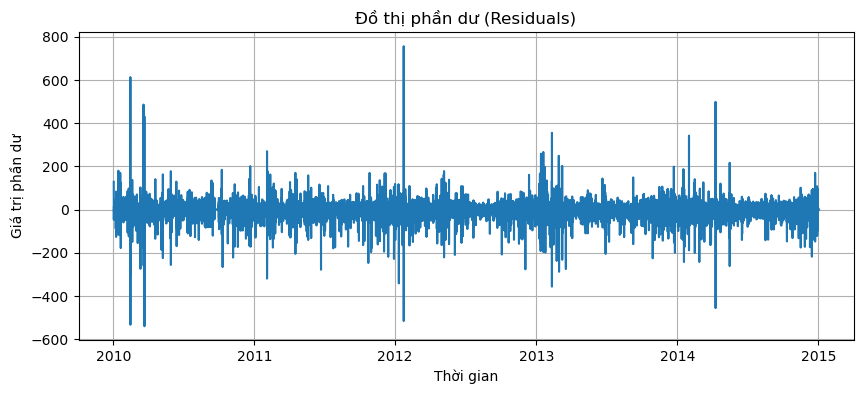

In [64]:
# Lấy phần dư
residuals = model_fit.resid

# Vẽ đồ thị phần dư
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Đồ thị phần dư (Residuals)')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị phần dư')
plt.grid(True)
plt.show()

<Figure size 1000x400 with 0 Axes>

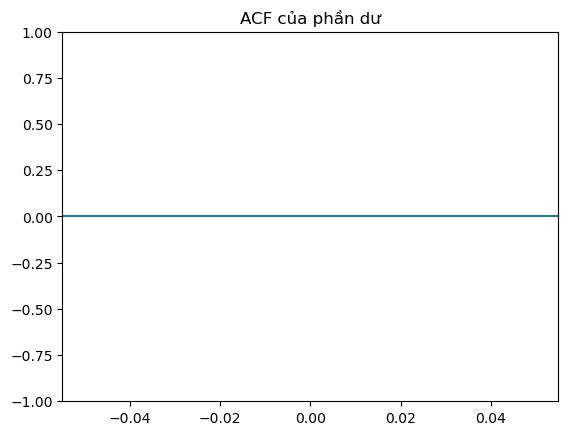

<Figure size 1000x400 with 0 Axes>

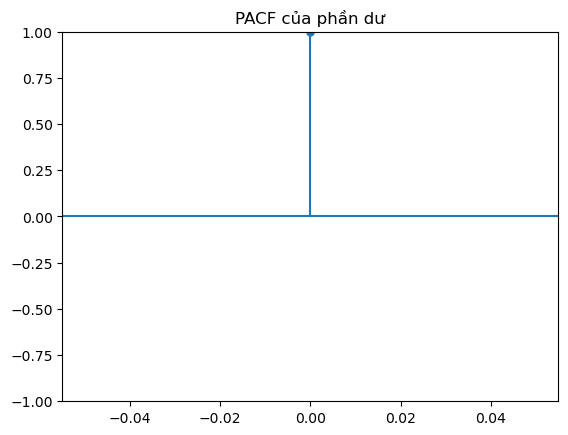

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ ACF của phần dư
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40)
plt.title('ACF của phần dư')
plt.show()

# Vẽ PACF của phần dư
plt.figure(figsize=(10, 4))
plot_pacf(residuals, lags=40)
plt.title('PACF của phần dư')
plt.show()

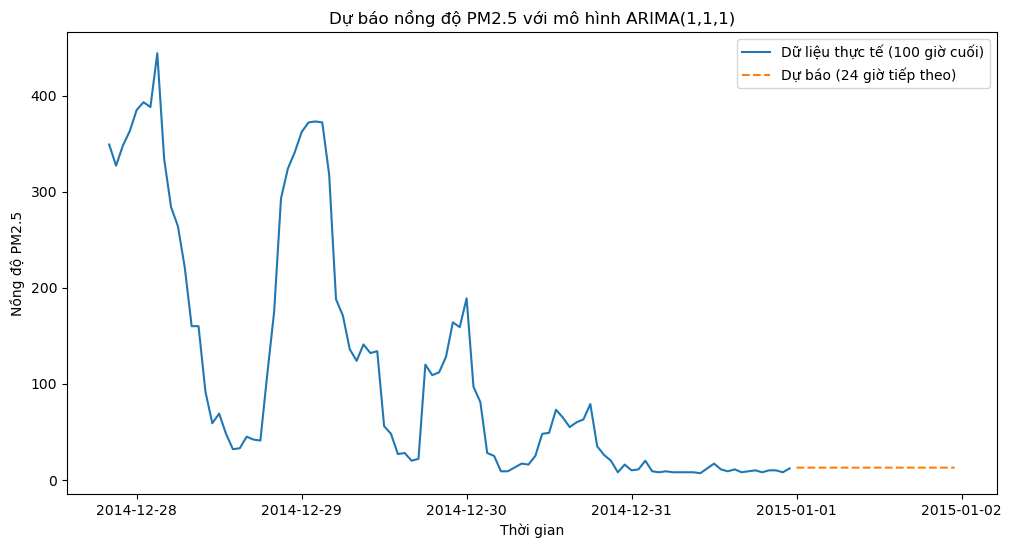

In [67]:
# Dự báo 24 bước (24 giờ) tiếp theo
forecast = model_fit.forecast(steps=24)
forecast_index = pd.date_range(start=pm25.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')

# Tạo DataFrame cho dự báo
forecast_df = pd.DataFrame(forecast.values, index=forecast_index, columns=['Forecast'])

# Vẽ biểu đồ so sánh dữ liệu thực tế và dự báo
plt.figure(figsize=(12, 6))
plt.plot(pm25[-100:], label='Dữ liệu thực tế (100 giờ cuối)')
plt.plot(forecast_df, label='Dự báo (24 giờ tiếp theo)', linestyle='--')
plt.title('Dự báo nồng độ PM2.5 với mô hình ARIMA(1,1,1)')
plt.xlabel('Thời gian')
plt.ylabel('Nồng độ PM2.5')
plt.legend()
plt.show()